<a href="https://colab.research.google.com/github/Sagargupta16/LeetCode_Rating_Predictor/blob/main/LC_Contest_Rating_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import json

In [27]:
# Define the GraphQL query.
query = """
query userContestRankingInfo($username: String!) {
  userContestRankingHistory(username: $username) {
    attended
    rating
    ranking
    problemsSolved
    contest {
      title
    }
  }
}
"""

# Headers for the request.
headers = {
    "Content-Type": "application/json",
}

# Function to read usernames from a JSON file
def read_usernames_from_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# List of usernames to query.
usernames = read_usernames_from_json('usernames.json')
# usernames = ["sagargupta1610"]

# Fetching data
input1 = []
input2 = []
input3 = []
input4 = []
input5 = []
output = []
for username in usernames:
    response = requests.post(
        "https://leetcode.com/graphql",
        headers=headers,
        json={"query": query, "variables": {"username": username}}
    )

    if response.status_code == 200:
        data = response.json()
        user_contest_history = data.get("data", {}).get("userContestRankingHistory", None)

        if user_contest_history is None:
            continue

        attended_contests = [contest for contest in user_contest_history if contest["attended"]]

        attended_contest_ratings_before_contest = [1500] + [contest["rating"] for contest in attended_contests]
        attended_contest_ratings_before_contest.pop()
        attended_contest_ratings_after_contest = [contest["rating"] for contest in attended_contests]
        attended_contest_rankings = [contest["ranking"] for contest in attended_contests]
        attended_problem_solved = [contest["problemsSolved"] for contest in attended_contests]
        attended_contest_type = [0 if word == "Weekly" else 1 if word == "Biweekly" else -1 for word in (contest["contest"]["title"].split()[0] for contest in attended_contests)]
        input1.extend(attended_contest_ratings_before_contest)
        input2.extend(attended_contest_rankings)
        input3.extend([r1 / r2 if r2 != 0 else 0 for r1, r2 in zip(attended_contest_ratings_before_contest, attended_contest_rankings)])
        input4.extend(attended_problem_solved)
        input5.extend(attended_contest_type)

        output.extend([after - before for after, before in zip(attended_contest_ratings_after_contest, attended_contest_ratings_before_contest)])
    else:
        print(f"Error fetching data for username {username}: {response.status_code}")


Error fetching data for username mitake_ran: 500
Error fetching data for username nomimon: 525
Error fetching data for username user6987q: 429
Error fetching data for username a0910089017: 429
Error fetching data for username M0u1ea5: 500


KeyboardInterrupt: ignored

In [28]:
# Create a DataFrame
df = pd.DataFrame({
    'input1': input1,  # attended_contest_ratings_before_contest
    'input2': input2,  # attended_contest_rankings
    'input3': input3,
    'input4': input4,
    'input5': input5,
    'output': output   # attended_contest_ratings_after_contest
})

# Display the DataFrame
print(df)
# Store DataFrame data in a JSON file
df.to_json('data.json', orient='records', lines=True)

# Prepare the data for the LSTM model (or any other model you are using)
X = df[['input1', 'input2', 'input3', 'input4', 'input5']].values
y = df['output'].values

          input1  input2     input3  input4  input5   output
0       1500.000     110  13.636364       4       0  320.626
1       1820.626      45  40.458356       4       0  199.425
2       2020.051      69  29.276101       4       1  102.787
3       2122.838     119  17.838975       4       0   73.217
4       2196.055     384   5.718893       4       0   19.398
...          ...     ...        ...     ...     ...      ...
192964  1751.332    1200   1.459443       3       0   27.884
192965  1779.216     610   2.916748       4       1   32.640
192966  1811.856    1733   1.045503       3       0   10.309
192967  1822.165    1501   1.213967       3       0   21.628
192968  1843.793    1505   1.225112       3       0   17.772

[192969 rows x 6 columns]


In [29]:

# Assuming X and y are your features and target variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input to be 3D [samples, time steps, features] for LSTM
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.001)

# Define LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', input_shape=(1, 5)),  # 100 hidden units
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Set a custom learning rate
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Epoch 1/10
6025/6025 [==============================] - 27s 4ms/step - loss: 599.2590
Epoch 2/10
6025/6025 [==============================] - 25s 4ms/step - loss: 493.8514
Epoch 3/10
6025/6025 [==============================] - 21s 4ms/step - loss: 462.8087
Epoch 4/10
6025/6025 [==============================] - 22s 4ms/step - loss: 452.3873
Epoch 5/10
6025/6025 [==============================] - 24s 4ms/step - loss: 444.9948
Epoch 6/10
6025/6025 [==============================] - 21s 4ms/step - loss: 438.9125
Epoch 7/10
6025/6025 [==============================] - 23s 4ms/step - loss: 434.6064
Epoch 8/10
6025/6025 [==============================] - 21s 4ms/step - loss: 431.9008
Epoch 9/10
6025/6025 [==============================] - 22s 4ms/step - loss: 428.5350
Epoch 10/10
7/7 [==============================] - 0s 3ms/step - loss: 353.9378
Test Loss: 353.9378356933594


7/7 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


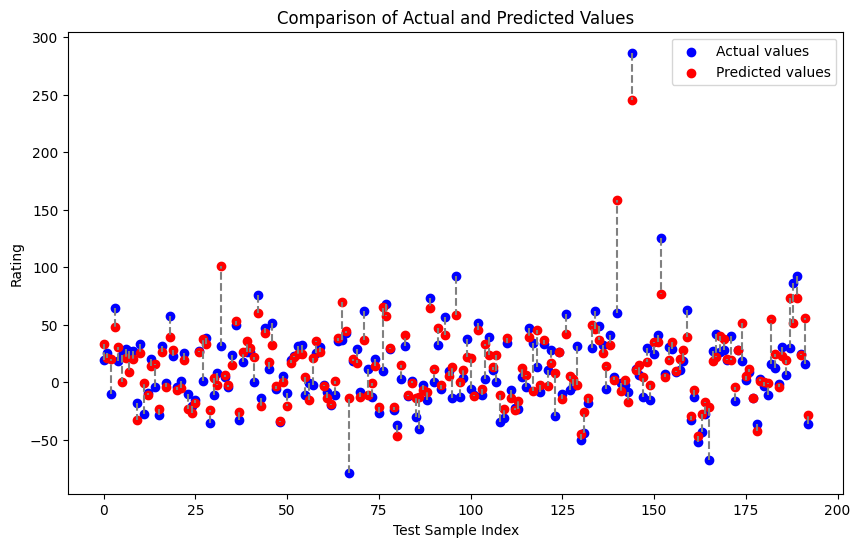

In [32]:
# Save the model
model.save('lC_Predictor.h5')

import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Flatten y_test and y_pred for plotting
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Plotting
plt.figure(figsize=(10, 6))

# Plot actual values
plt.scatter(range(len(y_test_flat)), y_test_flat, color='blue', label='Actual values')

# Plot predicted values
plt.scatter(range(len(y_pred_flat)), y_pred_flat, color='red', label='Predicted values')

# Draw lines between actual and predicted values
for i in range(len(y_test_flat)):
    plt.plot([i, i], [y_test_flat[i], y_pred_flat[i]], color='gray', linestyle='--')

# Adding title and labels
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Rating')

# Add legend
plt.legend()

# Display the plot
plt.show()


In [34]:
# New sample data for prediction
input1_pred = [1900, 1800, 2000, 1600, 1500]
input2_pred = [1500, 1000, 5000, 2000, 6000]
input3_pred = [r1 / r2 if r2 != 0 else 0 for r1, r2 in zip(input1_pred, input2_pred)]
input4_pred = [3,4,2,1,1]
input5_pred = [1,1,0,0,0]

# Combine the inputs into a single array
sample_data = np.array([input1_pred, input2_pred, input3_pred,input4_pred,input5_pred]).T  # Transpose to get the correct shape

# Scale the sample data
sample_data_scaled = scaler.transform(sample_data)

# Reshape the data for LSTM (samples, time steps, features)
sample_data_reshaped = sample_data_scaled.reshape((sample_data_scaled.shape[0], 1, sample_data_scaled.shape[1]))

# Predict with the LSTM model
predictions = model.predict(sample_data_reshaped)

# Print predictions
print("Predictions:", predictions)

1/1 [==============================] - 0s 22ms/step
Predictions: [[ 17.81577 ]
 [ 52.05607 ]
 [-24.531628]
 [-11.713746]
 [ -8.846079]]
